# Comparing Option Pricing Methods in kdb+/q

In this notebook, we compare the use of both **Monte Carlo** (MC) and **Quasi-Monte Carlo** (QMC) methods in the process of pricing Asian and European call options. In doing so, we consider the use of two discretization schemes - **standard discretization** and **Brownian bridge construction**. The **Black-Scholes** price for each market is compared to an average price generated using the following combinations of simulation and discretization methods:

- Pseudo-random number generation (MC) with standard discretization.
- Sobol sequences (QMC) with standard discretization.
- Sobol sequences (QMC) with Brownian Bridge construction.

Note that the methods demonstrated below follow the work presented in the paper [S. Kucherenko et. al 2007](http://www.broda.co.uk/gsa/wilmott_GSA_SK.pdf).

The Black-Scholes function for each market produces a closed form solution with a deterministic result, while the MC/QMC functions perform a number of random experiments and return an average price, based on the option type and the strike price.

Once both the Black-Scholes and MC/QMC prices have been calculated for each market, the RMSE can be calculated between the two. This is demonstrated in the final [example](#Example) below. The process is repeated for an increasing number of paths, with resulting errors compared.

### Requirements

The technical dependencies required to run this notebook are as follows:
- [embedPy](https://github.com/KxSystems/embedPy)
- [Sobol C++ library](https://www.broda.co.uk/software.html) - can be found within the option pricing library provided
- matplotlib

---

## Load q scripts

We start by loading in q scripts which include wrappers for the C++ random and sobol sequence number generators, along with the functions required to produce both cumulative and inverse cumulative normal distributions, and graphics functions used throughout this notebook.

In [1]:
\c 20 70
\l ../q/rand.q
\l ../q/norm.q
\l graphics/graphics.q

---

<a id='BS'></a>
## Black-Scholes Option Pricing

A common model used in finance to calculate the price of call options is Black-Scholes, where the formula required for each market is derived from the [Black Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). In this notebook, we look specifically at the Black-Scholes models for Asian and European call options. The function for each market produces a closed form solution with a deterministic result.

For [European call options](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model), the price of the corresponding option at time $t$, $P(S_{t},t)$, is given by:

$$\begin{eqnarray}
d_{1} = \frac{1}{\sigma\sqrt{T-t}}\Big[ln\Big(\frac{S_{t}}{K}\Big)+\Big((r-q)+\frac{\sigma^{2}}{2}\Big)(T-t)\Big]
\end{eqnarray}$$

$$\begin{eqnarray}
d_{2} = d_{1}-\sigma\sqrt{T-t}
\end{eqnarray}$$

$$\begin{eqnarray}
P(S_{t},t) = S_{t}e^{-q(T-t)}N(d_{1})-Ke^{-r(T-t)}N(d_{2})
\end{eqnarray}$$

Where $T$ is the expiry, $S_{t}$ is the price of the underlying asset at time $t$, $K$ is the strike price of the option, $\sigma$ is the volatility and $r$ is the interest rate. Note that the price is discounted by the dividends, $q$, throughout.

For Asian call options, we implement the same formula, using an adjusted $S_{t}$ and $\sigma^{2}$:

$$\begin{eqnarray}
\mu_{adj} = \frac{1}{2}\Big(r-\frac{\sigma}{2}\Big)\Big(1+\frac{1}{n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
\sigma^{2}_{adj} = \frac{\sigma^2}{3}\Big(1+\frac{1}{n}\Big)\Big(1+\frac{1}{2n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
{S_{t}}_{adj} = S_{t}e^{\frac{1}{2}\sigma^{2}_{adj}(T-t)+\mu_{adj}-r}
\end{eqnarray}$$

Where $n$ is the number of timesteps.

q implementations of Black-Scholes are defined below following the Black-Scholes formula for each market outlined above.

In [2]:
/ European
bsEuroCall:{[pd]
  / Calculate volatility*sqrt delta T coefficient
  coeff:(v:pd`v)*sqrt t:pd`t;
  / Calculate d1
  d1:(log[pd[`s]%pd`k]+t*(pd[`r]-pd`q)+.5*v*v)%coeff;
  / Calculate d2
  d2:d1-coeff;
  / Calculate the option price - P(S,t)
  (pd[`s]*exp[neg t*pd`q]*cnorm1 d1) -
    pd[`k]*exp[neg t*pd`r]*cnorm1 d2 }

/ Asian
bsAsiaCall:{[n;pd]
  / Calculate adjusted drift rate
  adjmu:.5*((r:pd`r)-.5*v2:v*v:pd`v)*n1:1+1.%n;
  / Calculate adjusted volatility squared
  adjv2:(v2%3)*n1*1+.5%n;
  / Calculate adjusted price
  adjS :pd[`s]*exp(t:pd`t)*(hv2:.5*adjv2)+adjmu-r;
  / Calculate d1
  d1:(log[adjS%k:pd`k]+t*(r-q:pd`q)+hv2)%rtv2:sqrt adjv2*t;
  / Calculate d2
  d2:d1-rtv2;
  / Calculate the option price - P(S,t)
  (adjS*exp[neg q*t]*cnorm1 d1)-k*exp[neg r*t]*cnorm1 d2 }

The required parameters for each function must be specified in a dictionary prior to use and are as follows:
- `s` - Asset price at $t=0$
- `k` - Strike
- `v` - Volatility
- `r` - Interest rate
- `q` - Dividends
- `t` - Expiry

Note that the Black-Scholes price of an Asian call option is also dependent on the number of timesteps. Below we show an example with 512 timesteps.

In [3]:
nsteps:512                           / number of timesteps
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1   / parameter dictionary

/ Calculate BS price for European/Asian options
-1"European Black Scholes Price: ",string bseuro:bsEuroCall pd;
-1"Asian Black Scholes Price:    ",string bsasia:bsAsiaCall[nsteps]pd;

European Black Scholes Price: 10.45058
Asian Black Scholes Price:    5.556009


---

<a id='MC'></a>
## Monte Carlo and Quasi-Monte Carlo Simulations

A number of experiments, or trials, can be performed to show the difference between option prices generated using MC or QMC methods compared to the Black Scholes equivalents. In each experiment, we:
1. Randomly generate n random numbers, either pseudo-random (MC) or Sobol sequence (QMC).
2. Convert into a normal distribution using `invcnorm`.
3. Convert into a Wiener path random walk using standard discretization or Brownian bridge construction.
4. Convert into an asset-price path based on parameters:
    - s: Asset price at $t=0$
    - v: Volatility
    - r: Interest rate
    - q: Dividends
    - t: Expiry
5. Convert into an option price based on the option type and strike price, `k`.

The prices produced are then averaged to get a final predicted price.

In this section we demonstrate the process using Sobol sequences (QMC) paired with Brownian bridge construction.

### 1. Random number generation

In the example below, 512 random numbers are generated for both pseudo-random numbers and Sobol sequences, with results plotted for comparison.

Random numbers are generated using the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) number generator which has 1 parameter, the number of steps.

The Sobol sequence generator takes in 2 arguments, the index of the point (0 < i < 2<sup>31</sup> - 1) and the dimension of the Sobol sequence, i.e. the number of steps (0 < d < 1025).

In [4]:
/ Function to generate n random numbers in d dimensions
rdmngen:{[n;d](d;n)#mtrand3 d*n }

/ Function to generate n sobol numbers in d dimensions
sobngen:{[n;d]flip sobolrand[d]each 1+til n }

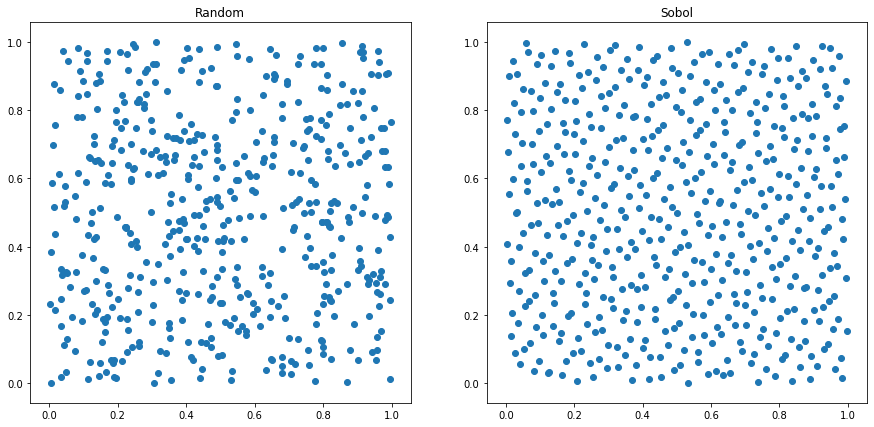

In [5]:
/ Generate n random and sobol numbers in 2D
data:(rdmngen;sobngen).\:nsteps,2
subplot[data;("Random";"Sobol");2;2#`scatter]

It is clear that the pseudo-random numbers are not evenly distributed, with a points clustering together in some sections, while leaving large portions of white space in others.

In contrast, the Sobol sequence plot exhibits a much more even distribution where points are better spaced out, with few points clumping together.

### 2. Convert to a Gaussian Distribution

The generated sequences are then converted from a uniform distribution to a gaussian distribution. Following this conversion, around 68% of the values lie within one standard deviation, while two standard deviations account for around 95% and three account for 99.7%.

<img src="graphics/gaussian.png" style="height:400px">

<u><b><center>[Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution)</center></b></u>

This is demonstrated using the inverse cumulative normal function, `invcnorm`.

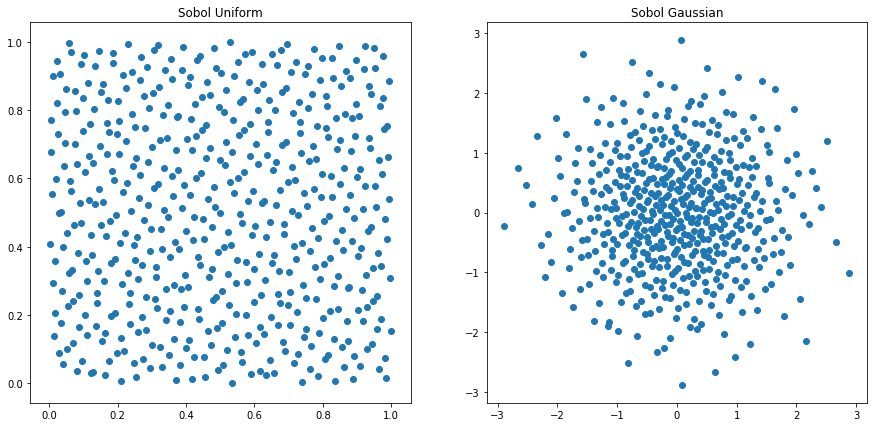

In [6]:
/ Convert sobol sequence to normal distribution
zsob:invcnorm each sob:last data
subplot[(sob;zsob);("Sobol Uniform";"Sobol Gaussian");2;2#`scatter]

Below we plot the 1D Gaussian distributions for both random and Sobol number generation across 64 timesteps.

In [7]:
/ Returns 1D Gaussian distribution to plot
gausscnv:{[g;n;d]first invcnorm each$[g~`rdm;rdmngen;sobngen][n;d] }

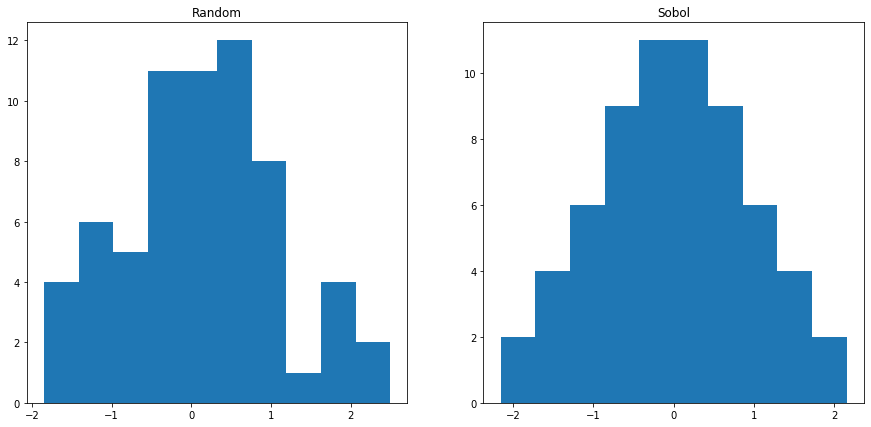

In [8]:
/ Calculates Gaussian variates for 64 steps, in 2 dimensions
dist:gausscnv[;64;2]each`rdm`sob
subplot[dist;("Random";"Sobol");2;2#`hist]

As expected the Sobol sequence exhibits a Gaussian curve with much better statistical properties than the random number sequence.

### 3. Convert into a Wiener path random walk

The starting point for asset price simulation is the construction of a Wiener path (or Brownian motion). Such paths are built from a set of independent Gaussian variates, using either standard discretization or Brownian-bridge construction.

In the standard approximation, the Wiener path is found by taking the cumulative sum of the Gaussian variates.

When constructing a Brownian bridge, the last step of the Wiener path is calculated first, followed by the mid-step, and then the space left between steps is bisected until all steps have been determined.

An example of building up a Brownian bridge is shown in the diagram below, where we have a total of 14 timesteps (from 1 to 14). Note that we also have an additional timestep 0, which is assumed to have a value of 0.

<img src="graphics/bbconstruct.png">

<u><center><b>The construction of a Brownian bridge over 14 steps</b> ([P. Jäckel 2001](http://inis.jinr.ru/sl/M_Mathematics/MV_Probability/MVspf_Stochastics%20in%20finance/Jaeckel%20Monte-Carlo.pdf))</center></u>

The q code to build both a Brownian bridge and Wiener path random walk are shown below.

Brownian bridge:

In [9]:
/* n  = number of timesteps
/* dt = length of timesteps
bbridge:{[n;dt]
  / create initial brownian bridge with indices for all timesteps
  bb:first flip(n-1).[util.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
  / calculate weights and sigma value for each point in the path
  bb:update lwt:bidx-lidx,rwt:ridx-bidx,sigma:ridx-lidx from bb;
  bb:update lwt%sigma,rwt%sigma,sigma:sqrt dt*lwt*rwt%sigma from bb;
  / create a projection for weiner path creation containing new bbridge
  util.buildpath .[bb;(0;`sigma);:;sqrt n*dt] }

Wiener path:

In [10]:
/ Performs cumulative sum 
/ or inverse cumulative normal for random/sobol numbers
/* u = gaussian variates
/* d = dictionary containing bbridge and boolean for sobol/random numbers
wpath:{[u;d]$[(::)~d`bb;sums;d`bb]invcnorm u }

Utilities:

In [11]:
/ Create an initial Brownian bridge
util.initbb:{[n;d;m]
  if[n<=j:1+d`ridx;j:0];
  d:`bidx`ridx`lidx!(l:j+(k-j+1)div 2;k:j+first where j _m;-1+j+:first where not j _m);
  (d;@[m;l;:;1b]) }

/ Create a path to follow
util.buildpath:{[bb;z]
  if[count[z]<>n:count bb;'`length];
  {[x;bb;z]
    @[x;bb`bidx;:;z+(x[bb`ridx]*bb`rwt)+$[0>l:bb`lidx;0;x[l]*bb`lwt]]
   }/[((n-1)#0.),z 0;1_bb;1_z*:bb`sigma] }

We can demonstrate how the Brownian bridge is built up using `bbdemolive` which will output a table with n timesteps, in this case $n = 8$, showing the order in which steps are added to the path. Note that `i0` is added here, where we assume that it has has a value equal to 0.

In [12]:
bbdemolive:{[n]
 x:1b,'enlist[n#0b],last flip(n-1).[util.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
 stp::n+1;bbd::"\n"vs .Q.s flip(`$"i",'string til count x)!x:flip(" X")x;}
.z.ts:{if[3<count bbd;-1 system syscmd;if[stp~count[bbd]-3;-1@'2#bbd];-1@'2_3#bbd;bbd::(2#bbd),3_bbd];}

In [13]:
\t 1000
bbdemolive 8


i0 i1 i2 i3 i4 i5 i6 i7 i8
--------------------------
X                         

X                       X 

X           X           X 

X     X     X           X 

X     X     X     X     X 

X  X  X     X     X     X 

X  X  X  X  X     X     X 

X  X  X  X  X  X  X     X 

X  X  X  X  X  X  X  X  X 


When recording the order of steps in the path, we take note of the left and right weights and indices, and the corresponding sigma value for each step in the sequence. This is shown for 512 timesteps and 1 unit of time, with the sigma value for each index in the Brownian bridge subsequently plotted.

In [14]:
dt:1
show 10#b:last value bbex:bbridge[nsteps;dt]

bidx ridx lidx lwt rwt sigma   
-------------------------------
511  511  511          22.62742
255  511  -1   0.5 0.5 11.31371
127  255  -1   0.5 0.5 8       
383  511  255  0.5 0.5 8       
63   127  -1   0.5 0.5 5.656854
191  255  127  0.5 0.5 5.656854
319  383  255  0.5 0.5 5.656854
447  511  383  0.5 0.5 5.656854
31   63   -1   0.5 0.5 4       
95   127  63   0.5 0.5 4       


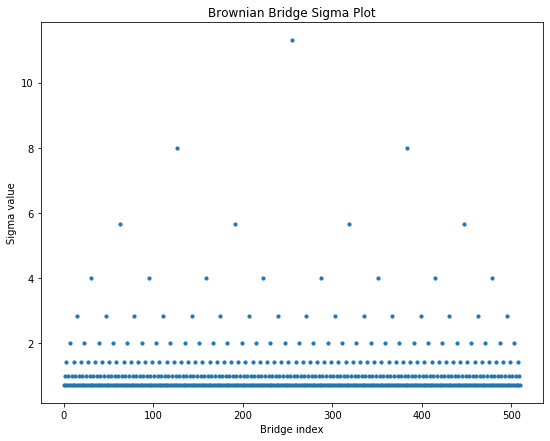

In [15]:
plt[`:figure]`figsize pykw 9 7;
plt[`:title]"Brownian Bridge Sigma Plot";
plt[`:scatter][;;10]. (1_b)`bidx`sigma;
plt[`:xlabel]"Bridge index";
plt[`:ylabel]"Sigma value";
plt[`:show][];

Once the Brownian bridge has been intialized, it can be used to transform Gaussian variates into a Wiener path random walk. In the cell below, a Wiener path with 512 timesteps is constructed using a Sobol sequence (of length 512) and the Brownian bridge constructed previously. Note that the function `wpath` takes the following arguments:
- `u` - Sequence of generated numbers, Sobol or random.
- `d` - Dictionary indicating whether to use standard discretization or Brownian bridge construction, and whether to use Sobol sequences (`1b`) or pseudo-random numbers (`0b`). If using a Brownian bridge, the initial Brownian bridge must be passed in, if not use `(::)`.

In [16]:
\c 200 110
d:`bb`sobol!(bbex;1b)
show w:wpath[sobolrand[nsteps;2];d]

-0.4450092 0.06385387 -0.1017726 -1.221271 -0.9099617 -1.552524 -0.5667251 -0.5347982 -0.3631799 -1.145434 ..


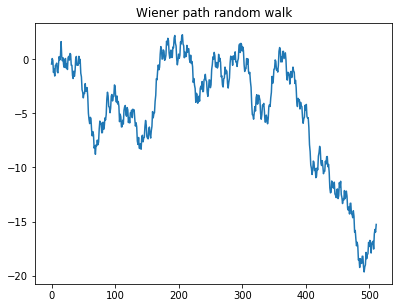

In [17]:
plt[`:title]"Wiener path random walk";
plt[`:plot]w;
plt[`:show][];

### 4. Convert into asset price path

At this point, the Wiener path is converted into an asset-price path using the methods outlined in [S. Kucherenko et al. 2007](http://www.broda.co.uk/gsa/wilmott_GSA_SK.pdf "Wilmott"), where the asset-price path is calculated as:

$$\begin{eqnarray}
S(t) = S_{0}exp\Big[(r-\frac{1}{2}\sigma^{2})t+\sigma W(t)\Big]
\end{eqnarray}$$

Where $S_0$ and $S(t)$ are the asset prices at time $0$ and $t$ respectively, $r$ is the interest rate, $\sigma$ is the volatility and $W(t)$ is a Wiener path up to time $t$.

This process can be done using the function `spath`, detailed below.

In [18]:
/* u  = guassian variates
/* n  = number of timesteps
/* d  = dictionary with bbridge and boolean for random/sobol
/* pd = dictionary of parameters s,v,r,t,q
spath:{[u;n;d;pd]
  / Original asset price
  pd[`s]*
   / Wiener path*volatility*time for one timestep
   exp(wpath[u;d]*pd[`v]*sqrt dt)+
    / Calculate sum of interest rate (discounted by dividends)
    /  and half volitility squared for each timestep
    (1+til n)*(pd[`r]-pd[`q]+.5*v*v:pd`v)*dt:pd[`t]%n }

Here we calculate six different asset price paths and overplot them for comparison. We start by generating the Sobol sequences for 8 paths with 512 timesteps, incrementing the Sobol index each time. Brownian bridge approximation is also used.

In [19]:
-1"Generated sequences: \n";
show u:sobolrand[nsteps;]each 2+til 8;

Generated sequences: 

0.25   0.75   0.25   0.75   0.25   0.75   0.25   0.25   0.75   0.75   0.25   0.25   0.75   0.75   0.25   0...
0.75   0.25   0.75   0.25   0.75   0.25   0.75   0.75   0.25   0.25   0.75   0.75   0.25   0.25   0.75   0...
0.375  0.625  0.125  0.875  0.875  0.125  0.625  0.125  0.875  0.625  0.125  0.375  0.375  0.125  0.625  0...
0.875  0.125  0.625  0.375  0.375  0.625  0.125  0.625  0.375  0.125  0.625  0.875  0.875  0.625  0.125  0...
0.125  0.375  0.375  0.125  0.625  0.875  0.875  0.375  0.125  0.375  0.375  0.125  0.625  0.875  0.875  0...
0.625  0.875  0.875  0.625  0.125  0.375  0.375  0.875  0.625  0.875  0.875  0.625  0.125  0.375  0.375  0...
0.3125 0.3125 0.6875 0.5625 0.1875 0.0625 0.9375 0.5625 0.0625 0.8125 0.1875 0.6875 0.6875 0.6875 0.1875 0...
0.8125 0.8125 0.1875 0.0625 0.6875 0.5625 0.4375 0.0625 0.5625 0.3125 0.6875 0.1875 0.1875 0.1875 0.6875 0...


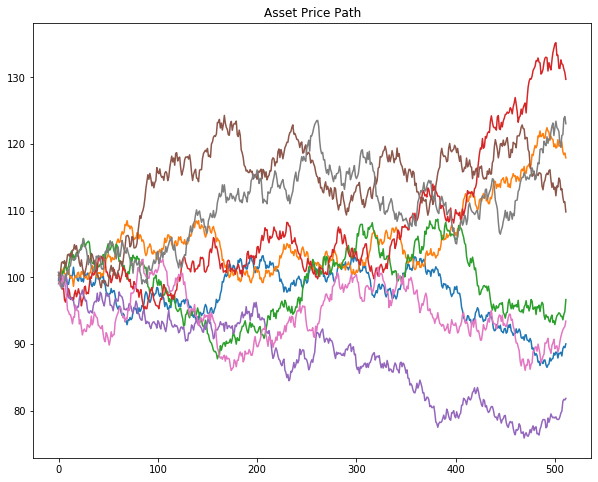

In [20]:
plt[`:figure][`figsize pykw 10 8];
plt[`:title]"Asset Price Path";
plt[`:plot] each spath[;nsteps;d;pd]each u;
plt[`:show][];

### 5. Convert into option price

Lastly, to find a single option price, an average is taken across the asset-price path for the MC/QMC method. This allows for comparison between the predicted price and the Black-Scholes equivalent. The formulae for both the European and Asian options are outlined in [S. Kucherenko et al. 2007](http://www.broda.co.uk/gsa/wilmott_GSA_SK.pdf "Wilmott").

For a European call option, the final MC/QMC price is calculated using: 

$$\begin{eqnarray}
C = e^{-rT} \Big[\frac{1}{N}\sum^{N}_{i=1} max(S^{(i)}_{T}-K,0)\Big]
\end{eqnarray}$$

Where $C$ is the final price of the call option, $r$ is the interest rate, $T$ is the length of timestep, $N$ is the finite number of simulated price paths and $K$ is the strike price. Note that $max(S^{(i)}_{T}-K,0)$ represents the [payoff for a call option](https://en.wikipedia.org/wiki/Option_style#American_and_European_options).

This has been translated into the below function:

In [21]:
/ MC/QMC Price of European Call Option
/* m  = number of paths
/* n  = number of timesteps
/* d  = dictionary with bbridge and boolean for random/sobol
/* pd = dictionary of parameters s,v,r,t,q
mcEuroCall:{[u;n;d;pd]
  exp[neg pd[`r]*pd`t]*avg 0 |
    (last each spath[;n;d;pd]each u)-pd`k }

Similarly, for Asian call options, the below is used:

$$\begin{eqnarray}
C = e^{-rT} \int_{H^{n}} max[0,(S^{(i)}_{t})^{1/n}-K] du_{1}...du_{n}
\end{eqnarray}$$

Where we integrate over unit hypercube $H^{n}$. In this case, the payoff for an geometric average Asian call option is calculated as the maximum between 0 and the geometric average of the underlying price, $S(t)$, minus the strike price, $K$.

The final price for an Asian call option can therefore be determined generated by using the below function:

In [22]:
/ MC/QMC Price of Asian Call Option
/* m  = number of paths
/* n  = number of timesteps
/* d  = dictionary with bbridge and boolean for random/sobol
/* pd = dictionary of parameters s,v,r,t,q
mcAsiaCall:{[u;n;d;pd]
  exp[neg pd[`r]*pd`t]*avg 0 |
    ((*/)each xexp[;1%n]spath[;n;d;pd]each u)-pd`k }

We also need a number-generator function for `l` trials, `m` paths and `n` steps which can be used with the Sobol’ or random-number generators.

In [23]:
/ Number generator function for l trials, m paths and n steps --can be used with sobol or random
numgen:{[ng;l;m;n]ng@''$[ng~mtrand3;(l;first m)#n;(0N;m)#1+til l*m] }

We demonstrate how to run these functions below for 512 timesteps, 256 paths and 5 trials. Sequences are generated for Sobol sequences using the above `numgen` function which will produce a sequence for each path and each trial.

In [24]:
ntrials:5
npaths:256

In [25]:
-1"Generated sequences:\n";
show 5#u:first numgen[sobolrand nsteps;ntrials;npaths;nsteps]

Generated sequences:

0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  ..
0.25  0.75  0.25  0.75  0.25  0.75  0.25  0.25  0.75  0.75  0.25  0.25  0.75  0.75  0.25  0.25  0.75  0.75 ..
0.75  0.25  0.75  0.25  0.75  0.25  0.75  0.75  0.25  0.25  0.75  0.75  0.25  0.25  0.75  0.75  0.25  0.25 ..
0.375 0.625 0.125 0.875 0.875 0.125 0.625 0.125 0.875 0.625 0.125 0.375 0.375 0.125 0.625 0.375 0.625 0.375..
0.875 0.125 0.625 0.375 0.375 0.625 0.125 0.625 0.375 0.125 0.625 0.875 0.875 0.625 0.125 0.875 0.125 0.875..


In [26]:
-1"European Monte Carlo Price: ",string mcEuroCall[u;nsteps;`bb`sobol!(bbex;1b);pd];
-1"Asian Monte Carlo Price:    ",  string mcAsiaCall[u;nsteps;`bb`sobol!(bbex;1b);pd];

European Monte Carlo Price: 10.28224
Asian Monte Carlo Price:    5.365942


Remembering that the Black-Scholes option prices for the same number of timesteps were:

In [27]:
-1"European Black-Scholes Price: ",string bseuro;
-1"Asian Black-Scholes Price:    ",string bsasia;

European Black-Scholes Price: 10.45058
Asian Black-Scholes Price:    5.556009


---

<a id='Example'></a>
## Example

In this section we deploy all of the aforementioned techniques and compare the results.

Note that the below example can be run from the terminal across multiple threads using the following commands:

```q
$ q -s 8
q)\l op.q
q)loadfile`:init.q
q)loadfile`:code/q/run.q
```
where we load in the functions contained within the Option Pricing library using the first two commands and run the example by loading in `run.q`.

### Parameters

As shown previously, a dictionary of parameters is created which contains the initial asset price `s`, volatility `v`, interest rate `r`, dividends `q`, expiry `t` and strike price `k`.

In [28]:
show pd:`s`k`v`r`q`t!100 100 .2 .05 0 1

s| 100
k| 100
v| 0.2
r| 0.05
q| 0
t| 1


We also need to initialize the number of paths (experiments), steps and trials.

In [29]:
l:20                        / Number of trials
n:1024                      / Number of steps
show m:"j"$xexp[2;3+til 8]  / Number of paths

8 16 32 64 128 256 512 1024


Given that the initial Brownian bridge will be the same throughout, it can also be initialized and passed in as an argument.

In [30]:
show 10#last value bb:bbridge[n;1]

bidx ridx lidx lwt rwt sigma   
-------------------------------
1023 1023 1023         32      
511  1023 -1   0.5 0.5 16      
255  511  -1   0.5 0.5 11.31371
767  1023 511  0.5 0.5 11.31371
127  255  -1   0.5 0.5 8       
383  511  255  0.5 0.5 8       
639  767  511  0.5 0.5 8       
895  1023 767  0.5 0.5 8       
63   127  -1   0.5 0.5 5.656854
191  255  127  0.5 0.5 5.656854


### Run experiments
The below functions calculate the RMSE between the Black Scholes and MC/QMC prices for each market and each MC/QMC technique. Note that we reset the `sobolrand` index after each set of trials have been completed.

In [31]:
/ Run all techniques for option pricing
/* bb  = initial brownian bridge
/* pd  = dictionary of parameters
/* l   = number of trials
/* n   = number of timesteps
/* m   = number of paths
runall:{[bb;pd;l;n;m]
  / Start timer for European options
  st:.z.p;
  / Output column names
  0N!util.rcol;
  / Run experiments for European options
  e:util.run[`euro;bsEuroCall pd;bb;pd;l;n]each m;
  / Output total time taken for European
  -1"European: time taken = ",string[.z.p-st],"\n";
  / Start timer for Asian options
  st:.z.p;
  / Output column names
  0N!util.rcol;
  / Run experiments for Asian options
  a:util.run[`asia;bsAsiaCall[n;pd];bb;pd;l;n]each m;
  / Output total time taken for Asian
  -1"Asian: time taken = ",string .z.p-st;
  / Return table with European and Asian prices and errors
  e,a }

/ Dictionary keys
util.d:`bb`sobol! 

/ Output column names
util.rcol:`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm,
  `prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs

/ RMSE
util.rmse:{sqrt avg x*x-:y}

/ Run each technique for a specific market
/* mkt = market, European/Asian
/* bs  = Black-Scholes price
util.run:{[mkt;bs;bb;pd;l;n;m]
  / Create project with correct MC function for each market
  mc:$[mkt~`asia;mcAsiaCall;mcEuroCall][;n;;pd];
  / Generate MC option price and calculate error for bbridge and sobol
  ea:util.rmse[bs]a:mc[;util.d(bb;1b)]each sob:numgen[sobolrand n;l;m;n];
  / Generate MC option price and calculate error for standard and sobol
  eb:util.rmse[bs]b:mc[;util.d(::;1b)]each sob;
  / Generate MC option price and calculate error for bbridge and random
  ec:util.rmse[bs]c:mc[;util.d(bb;0b)]each numgen[mtrand3;l;m;n];
  / Return dictionary of results
  util.rcol!0N!(mkt;m;ea;eb;ec;last a;last b;last c;bs) }

In [32]:
r:runall[bb;pd;l;n;m]

`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
(`euro;8;2.218523;3.328543;5.209454;13.86836;4.627863;20.38541;10.45058)
(`euro;16;1.345787;2.442911;3.676035;9.206011;12.88644;12.20984;10.45058)
(`euro;32;0.6865024;1.623545;3.015535;9.879788;11.36182;5.68257;10.45058)
(`euro;64;0.3774031;0.9891046;1.967627;10.90519;11.03423;9.034532;10.45058)
(`euro;128;0.2089234;0.5977986;1.619673;10.34505;11.26803;7.360597;10.45058)
(`euro;256;0.117329;0.3648233;1.065048;10.52265;10.26664;8.453786;10.45058)
(`euro;512;0.05984563;0.3127605;0.7586819;10.50504;9.799289;11.4056;10.45058)
(`euro;1024;0.03176637;0.2853521;0.3566248;10.43112;10.29892;11.01441;10.45058)
European: time taken = 0D00:04:23.025764000

`mkt`npaths`rmse_bb_sobol`rmse_std_sobol`rmse_std_rdm`prx_bb_sobol`prx_std_sobol`prx_std_rdm`prx_bs
(`asia;8;1.044296;2.126291;2.367783;6.461112;5.220244;7.388339;5.551409)
(`asia;16;0.6879741;1.37292;1.377341;4.369775;6.440017;7.051311;5.551409)


### Compare results

At this stage it was possible to plot the results we obtained for the option prices, RMSE and log RMSE values.

#### Option Prices

The plot below shows the option prices produced for each number of paths, compared to the Black-Scholes equivalent (black dashed-line). It is clear that the Sobol-Brownian bridge method (blue) converged the fastest.

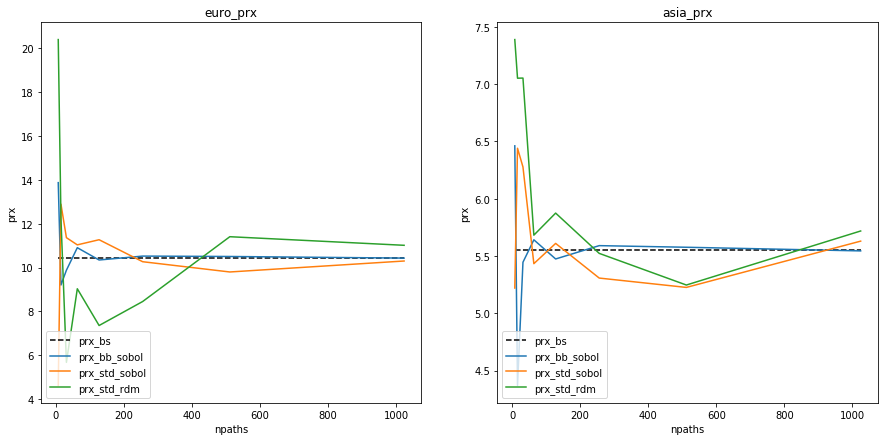

In [33]:
prxerrplot[r;`prx]

#### RMSE
We can also plot the RMSE produced by comparing the prices for each method as they converge to the relative Black-Scholes price. The expected result is again exhibited.

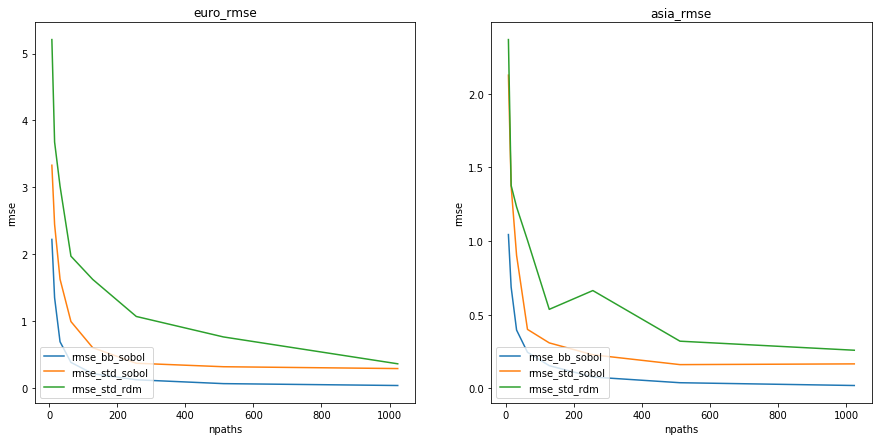

In [34]:
prxerrplot[r;`rmse]

#### Log RMSE
Lastly, we also look at the log RMSE plot as another means of comparison between the methods. Similarly, we see that the Sobol-Brownian bridge method (blue) exhibited superior performance.

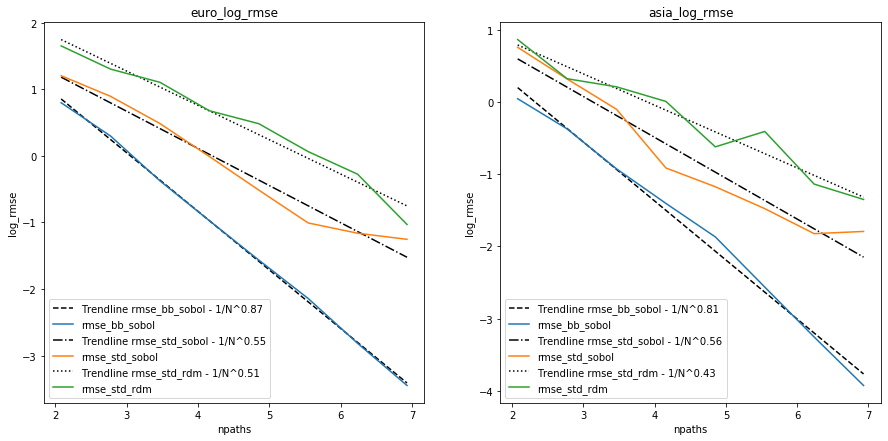

In [35]:
prxerrplot[r;`log]

---

## Conclusion

In this paper we demonstrated that it is possible to calculate option prices using both Black-Scholes and Monte Carlo/Quasi-Monte Carlo methods in kdb+/q. The Monte Carlo/Quasi-Monte Carlo methods deployed different implementations of both Wiener path approximation and random number generation.

Looking at the results produced, it is clear that both the option price produced and the resulting RMSE/log RMSE converged fastest when compared to the Black-Scholes price for the Quasi-Monte Carlo approach, with Sobol sequence number generation and Brownian bridge construction.

Additionally, by plotting results we have shown that the kdb+/q implementation replicates the original results produced in C++, presented in the paper S. Kucherenko et. al 2007.

---